In [ ]:
!python -m spacy download pt_core_news_sm
!pip install enelvo
!pip install googletrans==3.1.0a0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 11.0 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234910 sha256=367b96041c22f66f3e4e614e078fcaaf2b971ab91b559d5b34320912b1e4ffad
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 

In [ ]:
from google.colab import drive
import pandas as pd

from googletrans import Translator
from enelvo.normaliser import Normaliser
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Importando dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
chats_clients = pd.read_csv('/content/drive/Shareddrives/grupo3moshi/chats_clients.csv')
chats_clients.head()

,No,Intencao,Pergunta,Resposta
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...


# Pré-processamento

## 0) Base de Dados

In [ ]:
norm = Normaliser(tokenizer='readable')
chats_clients = pd.read_csv('/content/drive/Shareddrives/grupo3moshi/chats_clients.csv')
chats_clients.head()

,No,Intencao,Pergunta,Resposta
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...


In [ ]:
chats_clients.fillna('erro ao processar a pergunta', inplace=True)

In [ ]:
nlp_pt = spacy.load("pt_core_news_sm")

In [ ]:
def correct_grammar(text):
  return norm.normalise(text)

## 1) Reconhecimento de Nomes de Entidades

In [ ]:
def extract_ents(text):
    # Verify if it is a valid text
    if not isinstance(text, str):
        return []

    #  Use the portuguese model to process the text
    doc_pt = nlp_pt(text)

    # Place named entities in a dictionary
    ents = [{f'{ent.text}': ent.label_} for ent in doc_pt.ents]
    return ents

## 2) Tokenização

A Tokenização consiste no processo de divisão de um texto em partes menores, tokens, sejam elas palavras, caracteres ou até frases, de forma que o modelo de LLM possa processar e manipular os tokens com os algoritmos. Esse processo é a primeira etapa do treinamento do modelo e essencial para o resultado das outras etapas. ([Fonte](https://learn.microsoft.com/pt-br/dotnet/ai/conceptual/understanding-tokens))

In [ ]:
def tokenize(text):
  doc = nlp_pt(text)
  tokens = [token.text for token in doc if not token.is_punct]
  return tokens

## 3) Remoção de Stop Words


A etapa de remoção de Stop Words é um processo de refinamento e eliminação de palavras irrelevantes para o processamento do modelo de LLM, ao consultar em uma lista de palavras irrelevantes no idioma em questão. Assim, a dimensionalidade do problema é diminuída e a eficiência do modelo aumentada com a eliminação de palavras irrelevantes, como "a", "e", "de". ([Fonte](https://fineproxy.org/pt/wiki/stopword-removal/#:~:text=A%20remo%C3%A7%C3%A3o%20de%20palavras%20de,automatizado%20e%20classifica%C3%A7%C3%A3o%20de%20textos.))

In [ ]:
def remover_stop_words(tokens):
  stop_words = set(stopwords.words('portuguese'))
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
  return filtered_tokens

## 4) Lematização

A Lematização é o processo de extrair o infinitivo dos verbos, de forma que haja uma padronização na utilização das palavras. Isso é importante para a rede reconhecer de forma mais simples os padrões entre os tokens. ([Fonte](https://blog.bitso.com/pt-br/criptomoedas/diferenca-entre-tokenizacao-e-lematizacao#:~:text=Lematiza%C3%A7%C3%A3o%20%C3%A9%20um%20tipo%20de,fim%20de%20simplificar%20a%20palavra.))

In [ ]:
def lemmatize(text):
    text = ' '.join(text)
    doc = nlp_pt(text)
    lemmatized_token = [token.lemma_ for token in doc]

    return lemmatized_token

## 5) Remover listas vazias

Essa parte remove as listas vazias para não ter problema ao fazer o bag of words, tentando criar o BoW sendo que não tem palavra alguma.

In [ ]:
def remove_empty_lists(df):
    df = df[~df['Pergunta'].apply(lambda x: isinstance(x, list) and len(x) == 0)]
    return df

## 6) Remover números

Remove os números para o bag of words ser mais otimizado. Não há motivo para considerar números no vocabluário.

In [ ]:
def remove_numbers(text):
    text_no_numbers = [token for token in text if not token.isdigit()]
    for i, token in enumerate(text_no_numbers):
        for letter in token:
            if letter.isdigit():
                token = token.replace(letter, '')
        text_no_numbers[i] = token
    return text_no_numbers

## Aplicação da Pipeline completa

A fim de simplificar o pré-processamento, junta-se todos os processos empregados na seguite função até então (em desenvolvimento)

In [ ]:
def pre_processsing(df):
  df['Pergunta'] = df['Pergunta'].apply(correct_grammar)
  df['Pergunta - NER'] = df['Pergunta'].apply(extract_ents)
  df['Pergunta'] = df['Pergunta'].apply(tokenize)
  df['Pergunta'] = df['Pergunta'].apply(remove_numbers)
  df['Pergunta'] = df['Pergunta'].apply(remover_stop_words)
  df['Pergunta'] = df['Pergunta'].apply(lemmatize)
  df = remove_empty_lists(df)
  df['Resposta'] = df['Resposta'].apply(correct_grammar)
  df['Resposta - NER'] = df['Resposta'].apply(extract_ents)
  df['Resposta'] = df['Resposta'].apply(tokenize)
  df['Resposta'] = df['Resposta'].apply(remover_stop_words)
  df['Resposta'] = df['Resposta'].apply(lemmatize)


### Resultado Final

In [ ]:
pre_processsing(chats_clients)
chats_clients.head()

ERROR:enelvo.normaliser:Failed to normalise word "paypayginkou"!
ERROR:enelvo.normaliser:Failed to normalise word "onegaishimasu"!
ERROR:enelvo.normaliser:Failed to normalise word "zayrucard"!
ERROR:enelvo.normaliser:Failed to normalise word "brastelremit"!
ERROR:enelvo.normaliser:Failed to normalise word "onegaishimasu"!
ERROR:enelvo.normaliser:Failed to normalise word "onegaishimasu"!
ERROR:enelvo.normaliser:Failed to normalise word "mitsuisumitomo"!
ERROR:enelvo.normaliser:Failed to normalise word "incomodarmuito"!
ERROR:enelvo.normaliser:Failed to normalise word "onegaishimasu"!
ERROR:enelvo.normaliser:Failed to normalise word "onegaishimasu"!
ERROR:enelvo.normaliser:Failed to normalise word "ゆうちょ銀行"!
ERROR:enelvo.normaliser:Failed to normalise word "horariohttps"!
ERROR:enelvo.normaliser:Failed to normalise word "brastelremit"!
ERROR:enelvo.normaliser:Failed to normalise word "horariohttps"!
ERROR:enelvo.normaliser:Failed to normalise word "brastelremit"!
ERROR:enelvo.normaliser:F

,No,Intencao,Pergunta,Resposta,Pergunta - NER
0,1,Como depositar,"[bom, dia, tudo, bem, gostar, saber, sobre, ca...","Bom dia! Sim, o sr pode utilizar o cartão de d...",[{'marta verde': 'LOC'}]
1,2,Como fazer remessa,"[enviar, dinheiro, Japão]","Para se inscrever no serviço de remessa, por f...",[{'do japão': 'LOC'}]
2,3,Tempo de remessa,"[quanto, tempo, levar, beneficiário, receber, ...","Via de regra, as remessas serão pagas via PIX ...",[]
3,4,"Pedido de envio via metodo ""ByPhone""","[bom, tarde, acabar, fazer, transferência, +, ...",iremos processar a sua solicitacao.\nMuito obr...,[]
4,5,"Pedido de envio via metodo ""ByPhone""","[poder, fazer, remesso, yenes, bbb, rer, obrig...",iremos processar a sua solicitacao.\nMuito obr...,[{'bbb': 'MISC'}]


# Implementação da Função do Classificador Naive Bayes e seus respectivos testes

Abaixo estamos trabalhando o item 2 do artefato: **Implementação de Modelo Baseline (BoW com NB)**

O item 2 aborda detalhamente:

2 - Definição da função de treinamento do classificador Naive Bayes (NB) e seus respectivos testes;

Alguns valores estarão sendo mocados a fim de testar a função e otimizar o trabalho antes do treinamento completo que pode ser encontrado no dataset final do artefato (notebook este que unifica todos os itens).



## Bag Of Words

### Descrição do Bag of Words (BoW):

O **Bag of Words (BoW)** é uma técnica de representação de texto que transforma frases em vetores de números inteiros, onde cada posição do vetor corresponde a uma palavra do vocabulário e o valor nessa posição indica a frequência (ou presença) dessa palavra na frase. É uma abordagem simples e eficaz para converter texto em uma forma que pode ser processada por algoritmos de machine learning.

--

OPENCLASSROOMS. *Introduction to Natural Language Processing*. Disponível em: <https://openclassrooms.com/en/courses/6532301-introduction-to-natural-language-processing/8081284-apply-a-simple-bag-of-words-approach>. Acesso em: 21 ago. 2024.

In [ ]:
def bag_of_words(df, column):
  column_perguntas = [' '.join(sublista) for sublista in df[column]]
  vectorizer = CountVectorizer()
  bag_of_words = vectorizer.fit_transform(column_perguntas)
  return bag_of_words.toarray(), vectorizer

In [ ]:
# Gerando BoW para as setenças escolhidas anteriormente
bow_matrix, vectorizer = bag_of_words(chats_clients, 'Pergunta')

In [ ]:
# Exibindo a matriz BoW
print("Matriz BoW:\n", bow_matrix)
print("\nVocabulário:\n", vectorizer.get_feature_names_out())

Matriz BoW:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Vocabulário:
 ['abar' 'abençoar' 'abençoe' 'abo' 'abrir' 'acabar' 'acabeir' 'acessar'
 'acesso' 'achar' 'acima' 'acontecer' 'add' 'adicionar' 'admitir'
 'adquirir' 'agora' 'agradecir' 'agradeço' 'aguardar' 'aguardo' 'agência'
 'ah' 'ai' 'ainda' 'airo' 'ajudar' 'ajude' 'alegar' 'alegre' 'algo'
 'algum' 'alguém' 'allá' 'alterar' 'am' 'amanhã' 'amarelo' 'amigo' 'anna'
 'ano' 'antes' 'antigo' 'apaguei' 'aparecer' 'aparelho' 'aplicativo'
 'appplication' 'aproximadamente' 'após' 'aquele' 'aqui' 'ar' 'ario'
 'arrumar' 'aru' 'ary' 'assim' 'atar' 'ate' 'atenciosamente' 'atender'
 'atenção' 'ativar' 'ato' 'através' 'atual' 'atualizar' 'atualização'
 'atualizei' 'austrália' 'austráliar' 'av' 'avisar' 'azarar' 'aí' 'baixar'
 'baixei' 'banco' 'bancário' 'bater' 'bbb' 'beber' 'bebê' 'bem' 'ben'
 'beneficiár' 'beneficiária' 'beneficiário' 'ber' 'bloquear' 'boff' 'bom'


## Classificador Naive Bayes

O algoritmo baseado no Teorema de Bayes, classifica com a suposição "ingênua" (naive) de que todas as características (ou atributos) do conjunto de dados são independentes umas das outras.

**Teorema de Bayes**
O Teorema de Bayes fornece uma maneira de calcular a probabilidade de uma classe com base nas características observadas.

$$P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)}$$


Onde:
- \(P(C|X)\) é a probabilidade posterior da classe \(C\) dado o conjunto de características \(X\).
- \(P(X|C)\) é a probabilidade de observar o conjunto de características \(X\) dado que a classe é \(C\).
- \(P(C)\) é a probabilidade a priori da classe \(C\).
- \(P(X)\) é a probabilidade a priori do conjunto de características \(X\).

Existem diferentes variações do Naive Bayes, dependendo do tipo de dado. Para nosso caso o que melhor se encaixa é o Multinominal Naive Bayes.

**Multinomial Naive Bayes**: Usado principalmente para classificação de documentos, onde as características são as frequências de palavras.


_Referência_:

SCIKIT-LEARN. sklearn.naive_bayes.MultinomialNB. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#gallery-examples. Acesso em: 22 ago. 2024.

IBM. Naïve Bayes. Disponível em: https://www.ibm.com/topics/naive-bayes#:~:text=Na%C3%AFve%20Bayes%20is%20part%20of,important%20to%20differentiate%20between%20classes. Acesso em: 22 ago. 2024.

In [ ]:
class NaiveBayesClassifier:
  def __init__(self):
    self.classifier = MultinomialNB()

  def train(self, X_train, y_train):
    # Treina o classificador Naive Bayes com os dados fornecidos
    self.classifier.fit(X_train, y_train)

  def predict(self, X_test):
    # Faz previsões usando o modelo treinado
    return self.classifier.predict(X_test)

  def evaluate(self, y_test, y_pred):
    # Avalia o modelo usando a matriz de confusão e outras métricas
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    return cm, cr


**Separação dos dados em amostras de treino e amotras de teste**

A base de perguntas e intenções(classes) é dividida em conjunto de treino e teste, o quais serão usados para treinar e metrificar/validar o modelo desenvolvido.

In [ ]:
# Dividindo os dados em conjuntos de treino e teste
labels = chats_clients['Intencao'].tolist()
X_train, X_test, y_train, y_test = train_test_split(bow_matrix, labels, test_size=0.2, random_state=42)


In [ ]:
X_train, y_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 ['Confirmacao de cambio/taxas',
  'Registro/Atualizacao de Documento',
  'Acesso a conta',
  'Termos e condicoes do servico',
  'Como se inscrever',
  'Pedido de envio via metodo "ByPhone"',
  'Cancelamento',
  'Confirmacao de cambio/taxas',
  'Confirmacao de cambio/taxas',
  'Como se inscrever',
  'Cadastro de beneficiario',
  'Solicitacao de cartao de remessas',
  'Confirmacao de cambio/taxas',
  'Tempo de remessa',
  'Termos e condicoes do servico',
  'Confirmacao de cambio/taxas',
  'Termos e condicoes do servico',
  'Pedido de envio via metodo "ByPhone"',
  'Confirmacao de cambio/taxas',
  'Pedido de envio via metodo "ByPhone"',
  'Pedido de envio via metodo "ByPhone"',
  'Tempo de remessa',
  'Tempo de remessa',
  'Reembolso',
  'Confirmacao de cambio/taxas',
  'Cadastr

In [ ]:
print(f'Das 18 intenções o conjunto de treino tem: {len(set(y_train))}')

Das 18 intenções o conjunto de treino tem: 17


In [ ]:
# Instanciando a classe NaiveBayesClassifier
nb_classifier = NaiveBayesClassifier()

# Treinando o classificador
nb_classifier.train(X_train, y_train)

# Fazendo previsões
y_pred = nb_classifier.predict(X_test)

# Avaliando o classificador
confusion_matrix, classification_report = nb_classifier.evaluate(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Matriz de confusão
A matriz de confusão fornece uma visão detalhada de como o modelo está classificando as instâncias do conjunto de dados, permitindo a identificação precisa de acertos e erros, cruzando as previsões feitas pelo modelo com as verdadeiras classes das instâncias.

A diagonal principal da matriz de confusão (de cima à esquerda até embaixo à direita) representa todas as classificações corretas feitas pelo modelo, tanto para as classes positivas quanto negativas. Os valores fora da diagonal principal representam os erros de classificação.

Na matriz de confusão, existem quatro quadrantes principais:

**Verdadeiros Positivos:** Representa o número de instâncias que foram corretamente classificadas como pertencentes à classe positiva.

**Verdadeiros Negativos:** Indica o número de instâncias que foram corretamente identificadas como pertencentes à classe negativa. Assim como os verdadeiros positivos, essas são previsões corretas, mas referentes à não pertinência de uma instância à classe positiva.

**Falsos Positivos:** Referem-se ao número de instâncias que foram incorretamente classificadas como pertencentes à classe positiva. Nesse caso, o modelo previu uma classe positiva quando, na verdade, a instância pertencia à classe negativa.

**Falsos Negativos:** Representam as instâncias que foram incorretamente classificadas como pertencentes à classe negativa, quando na verdade deveriam ter sido classificadas como positivas.



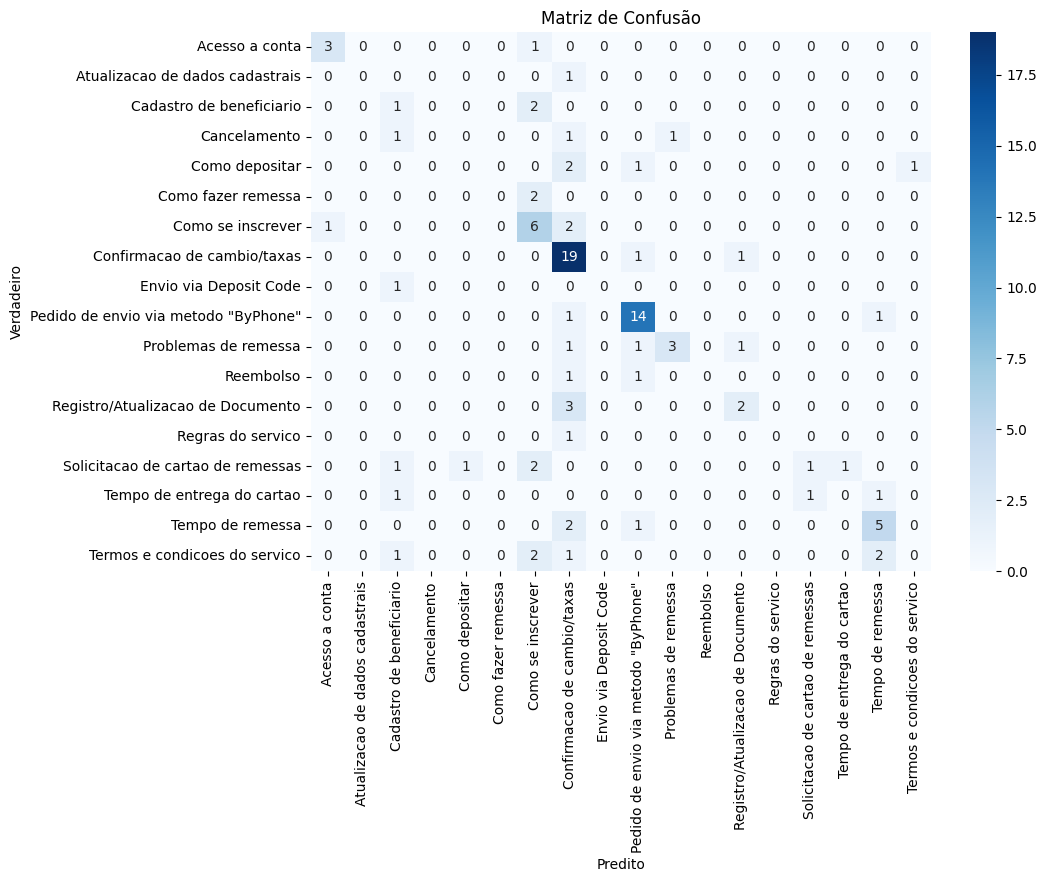

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

Ao analisarmos a matriz de confusão, observamos que o modelo apresenta um desempenho excelente ao classificar instâncias que contêm uma variedade maior de palavras, ou seja, frases que se diferenciam claramente das demais. Isso é evidente nos exemplos de "Confirmação de câmbio/taxas" e "Pedido de envio via método 'ByPhone'", onde o modelo conseguiu identificar corretamente devido à presença de termos específicos e únicos, que facilitam a distinção.

Por outro lado, o modelo ainda enfrenta dificuldades para classificar corretamente instâncias que compartilham palavras ou significados semelhantes, como é o caso de "Como fazer remessa" e "Tempo de remessa". Essas frases apresentam uma conexão semântica e um vocabulário parecido, o que torna mais difícil para o modelo diferenciá-las com precisão.

Para o nosso projeto, não é interessante que exista Falsos positivos ou falsos negativos.

## Análise dos resultados obtidos

In [ ]:
print(classification_report)

                                      precision    recall  f1-score   support

                      Acesso a conta       0.75      0.75      0.75         4
     Atualizacao de dados cadastrais       0.00      0.00      0.00         1
            Cadastro de beneficiario       0.17      0.33      0.22         3
                        Cancelamento       0.00      0.00      0.00         3
                      Como depositar       0.00      0.00      0.00         4
                  Como fazer remessa       0.00      0.00      0.00         2
                   Como se inscrever       0.40      0.67      0.50         9
         Confirmacao de cambio/taxas       0.54      0.90      0.68        21
              Envio via Deposit Code       0.00      0.00      0.00         1
Pedido de envio via metodo "ByPhone"       0.74      0.88      0.80        16
                Problemas de remessa       0.75      0.50      0.60         6
                           Reembolso       0.00      0.00      

A análise dos resultados mostra que o modelo apresenta limitações em termos de precisão e recall, especialmente em classes com baixa frequência de ocorrência. Por exemplo, para as classes "Cadastro de beneficiário" e "Solicitação de cartão de remessas", o modelo obteve um f1-score de 0.22 e 0.25, respectivamente, refletindo uma alta taxa de erros, tanto em falsos positivos quanto em falsos negativos. Isso é preocupante porque falsos positivos podem acionar respostas inadequadas, confundindo o usuário, enquanto falsos negativos podem resultar na falta de resposta para uma solicitação legítima, comprometendo a satisfação do usuário.

Minimizar tanto os falsos positivos quanto os falsos negativos é essencial para garantir que o sistema seja confiável e útil para o nosso contexto, onde uma classificação incorreta pode levar a consequências operacionais e prejudicar a experiência do usuário.